# <span style="color:orange"> Laboratorio di Simulazione Numerica </span>
## <span style="color:orange"> Esercitazione 7 </span>

### Paolo Panatti (12606A)

### <font color="blue"> Esercizio 07.1

#### Obiettivo:
Includere nel codice NSL_SIMULATOR il calcolo delle correzioni di coda per l'energia potenziale $U$ e la pressione $P$.

Nel codice dell'esercitazione $4$, il potenziale di interazione tra le particelle viene approssimato imponendo un cut-off sferico ad una distanza $r_c$. Questa approssimazione può introdurre un errore apprezzabile nella stima dell'energia potenziale e di altre quantità termodinamiche, come la pressione, per cui il nostro modello va a discostarsi da quello esatto di Lennard-Jones. Tuttavia, è possibile compensare la parte mancante a lungo range del potenziale introducendo le seguenti correzioni di coda (per energia potenziale e pressione rispettivamente):
$$\frac{\langle V_{LJ} \rangle_{tail}}{N} \simeq \frac{8\pi\rho_{LJ}\epsilon}{9r_{c(LJ)}^9} - \frac{8\pi\rho_{LJ}\epsilon}{3r_{c(LJ)}^3}$$
$$\frac{\langle w_{LJ} \rangle_{tail}}{3N\epsilon} \simeq 32\pi\rho_{LJ} \left[ \frac{1}{9r_{c(LJ)}^9} - \frac{1}{6r_{c(LJ)}^3} \right]$$
calcolate sfruttando il fatto che la media di ensamble di una qualsiasi funzione che dipende dalla distanza relativa tra due particelle può essere valutata conoscendo la funzione di distribuzione radiale $g(r)$ e assumendo $g(r) \approx 1$ per $r > r_c$.

In questo primo esercizio ho semplicemente implementato le due formule all'interno del codice.

### <font color="blue"> Esercizio 07.2

#### Obiettivo:
Eseguire una simulazione Monte Carlo $(N,V,T)$ e una simulazione di dinamica molecolare $(N,V,E)$ di una fase liquida per stimare approssimativamente quanto deve essere lungo ciascun blocco analizzando l'andamento dell'energia potenziale per particella $U/N$.

I parametri delle due simulazioni sono: $N=108$, $\rho^*=0.8$, $T^*=1.1$, $r_c^*=2.5$, $dt^*=0.001$ (time step dinamica molecolare). Nel caso Monte Carlo, il parametro $\delta$, che rappresenta l'ampiezza massima del passo in ogni direzione, è stato fissato a $0.1$ in modo da avere un'accettanza dell'algoritmo di Metropolis pari al $50\%$ circa.

Prima di effettuare le misure, ho dovuto eseguire in entrambi i casi una simulazione iniziale di $5000$ passi con configurazione di partenza fcc lasciando evolvere il sistema per raggiungere l'equilibrio termico. Nel caso MD (dinamica molecolare), la temperatura $T$ non è una costante del moto e quindi durante la fase di equilibrizione varia. Per questo motivo, ho dovuto impostare una temperatura iniziale più alta, pari a $2.0$, in modo tale che all'equilibrio la temperatura media del sistema si stabilizzi attorno al valore desiderato. Terminata questa prima fase, ho fatto ripartire le due simulazioni e ho registrato i valori istantanei dell'energia potenziale per particella $U/N$ utilizzando $5 \times 10^5$ blocchi da $1$ step ciascuno.

Con i dati raccolti ho poi calcolato le due funzioni di autocorrelazione e stimato le incertezze statistiche con il metodo data blocking al variare della lunghezza dei blocchi, da $L=10$ fino a $L=5\times10^3$.

Per il calcolo delle funzioni di autocorrelazione ho implementato la seguente formula:
$$\chi(t) = \frac{\displaystyle \frac{1}{t_{max}-t} \displaystyle \sum_{t'=0}^{t_{max}-t} U/N(t')U/N(t'+t) - \frac{1}{t_{max}-t} \displaystyle \sum_{t'=0}^{t_{max}-t} U/N(t') \times \frac{1}{t_{max}-t} \displaystyle \sum_{t'=0}^{t_{max}-t} U/N(t'+t)}{\displaystyle \frac{1}{t_{max}} \displaystyle \sum_{t'=0}^{t_{max}} U/N^2(t') - \left(\frac{1}{t_{max}} \displaystyle \sum_{t'=0}^{t_{max}} U/N(t')\right)^2}$$

Di seguito i grafici con tutti i risultati ottenuti.

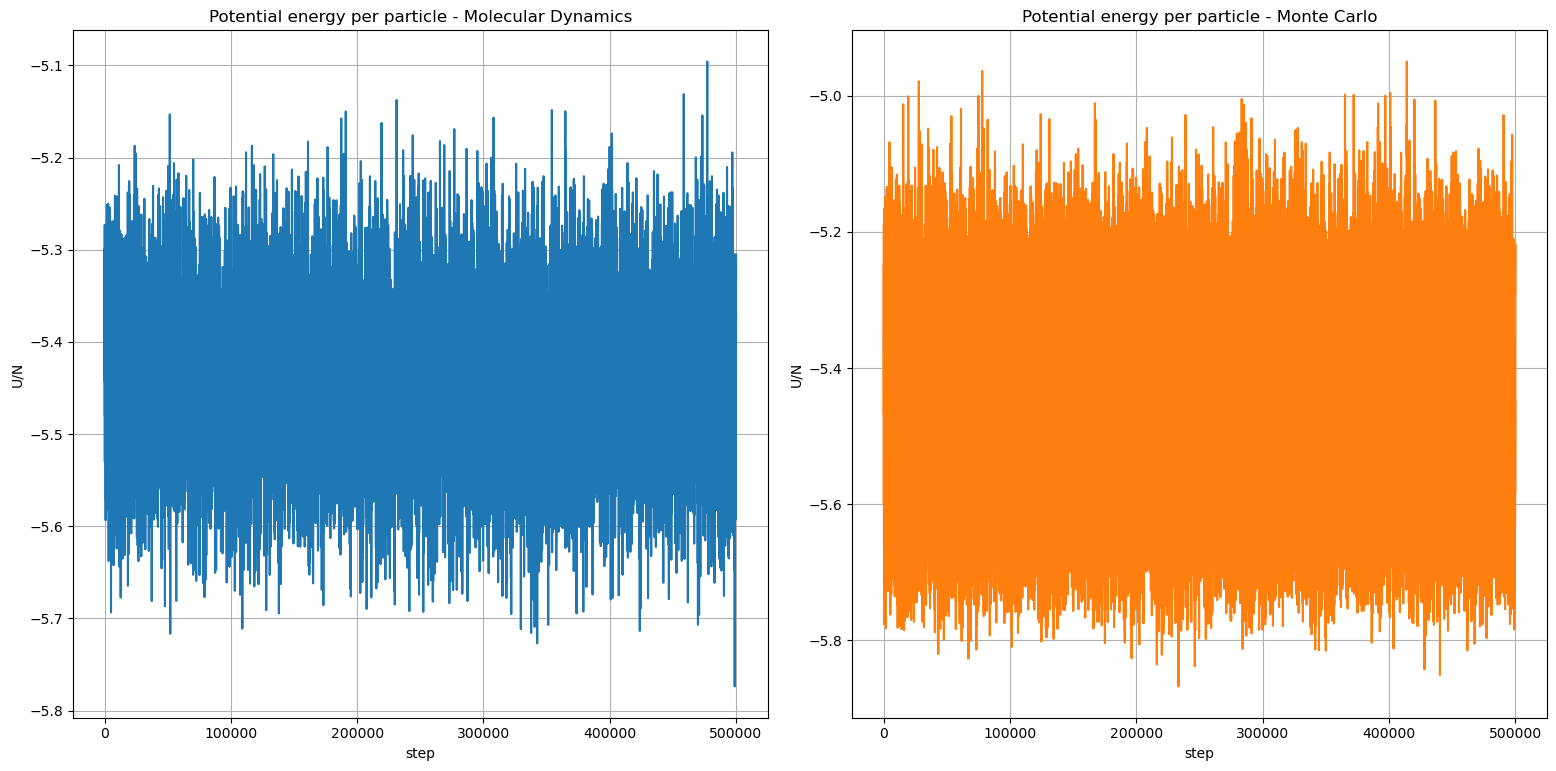

In [41]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

steps = np.arange(0,500000)+1
u_md = np.loadtxt("Es2/OUTPUT_MD/potential_energy.dat", usecols=1, unpack='true')
u_mc = np.loadtxt("Es2/OUTPUT_MC/potential_energy.dat", usecols=1, unpack='true')

fig, axes = plt.subplots(1, 2, figsize=(16,8))
fig.tight_layout(pad=3.0)

axes[0].plot(steps,u_md)
axes[0].set_xlabel('step')
axes[0].set_ylabel('U/N')
axes[0].set_title('Potential energy per particle - Molecular Dynamics')
axes[0].grid(True)

axes[1].plot(steps,u_mc,color='tab:orange')
axes[1].set_xlabel('step')
axes[1].set_ylabel('U/N')
axes[1].set_title('Potential energy per particle - Monte Carlo')
axes[1].grid(True)

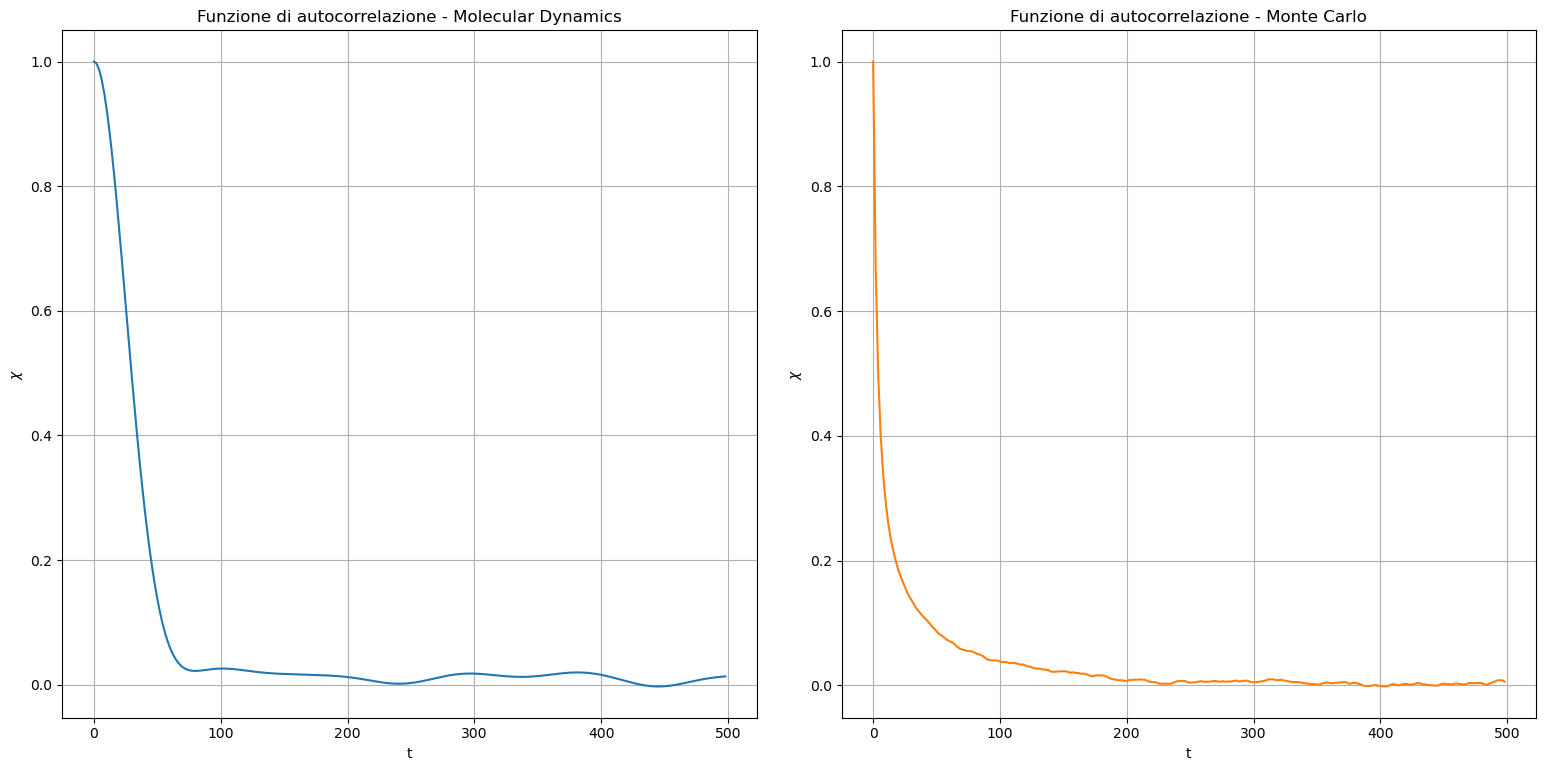

In [45]:
def autoC(t,vec):
    sum1 = 0
    sum2 = 0
    sum3 = 0
    sum4 = 0
    sum5 = 0
    tmax = vec.size
    for i in range(tmax-t):
        sum1 += vec[i]*vec[i+t]
        sum2 += vec[i]
        sum3 += vec[i+t]
    for i in range(tmax):
        sum4 += vec[i]**2
        sum5 += vec[i]
    return (1.0/(tmax-t)*sum1-1.0/(tmax-t)*sum2*1.0/(tmax-t)*sum3)/(1.0/tmax*sum4-(1/tmax*sum5)**2)

chi_md = np.zeros(250)
chi_mc = np.zeros(250)
for i in range(250):
    chi_md[i] = autoC(2*i,u_md)
    chi_mc[i] = autoC(2*i,u_mc)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
fig.tight_layout(pad=3.0)

axes[0].plot(2*np.arange(250),chi_md)
axes[0].set_xlabel('t')
axes[0].set_ylabel(r'$\chi$')
axes[0].set_title('Funzione di autocorrelazione - Molecular Dynamics')
axes[0].grid(True)

axes[1].plot(2*np.arange(250),chi_mc,color='tab:orange')
axes[1].set_xlabel('t')
axes[1].set_ylabel(r'$\chi$')
axes[1].set_title('Funzione di autocorrelazione - Monte Carlo')
axes[1].grid(True)

Entrambe le curve decadono rapidamente e si annullano per ritardi temporali $t > 200$ circa. Questo significa che due valori misurati ad almeno $200$ passi di distanza risultano a tutti gli effetti statisticamente indipendenti, essendo gli stati del sistema significativamente diversi tra loro. L'andamento della funzione di autocorrelazione ci aiuta quindi a stimare la dimensione dei blocchi ottimale per la tecnica data blocking: se vogliamo valutare correttamente le incertezze statistiche, dobbiamo utilizzare blocchi lunghi almeno $200$ passi. Così facendo, infatti, le medie di blocco risultano scorrelate e di conseguenza il Teorema del Limite Centrale può essere applicato.

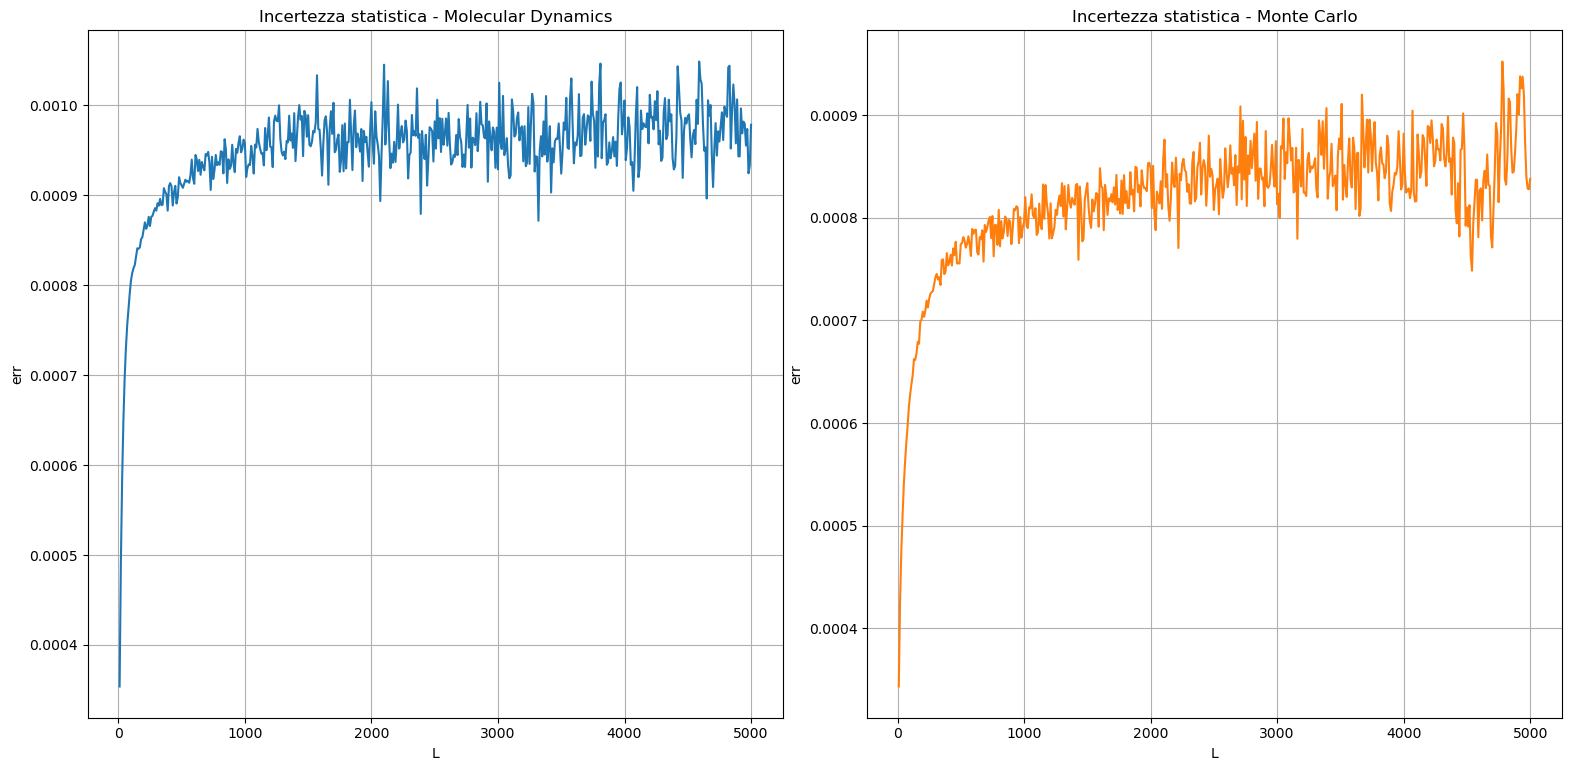

In [47]:
M = 500000
def DataBlocking(vec,L):
    N = int(M/L)
    mean = 0
    mean2 = 0
    for i in range(N):
        av = 0
        for j in range(L):
            av += vec[j+i*L]
        mean += (av/L)/N
        mean2 += ((av/L)**2)/N
    return math.sqrt((mean2-mean**2)/(N-1))

err_md = np.zeros(500)
err_mc = np.zeros(500)
for i in range(500):
    err_md[i] = DataBlocking(u_md,10*(i+1))
    err_mc[i] = DataBlocking(u_mc,10*(i+1))

fig, axes = plt.subplots(1, 2, figsize=(16,8))
fig.tight_layout(pad=3.0)

axes[0].plot(10*(np.arange(500)+1),err_md)
axes[0].set_xlabel('L')
axes[0].set_ylabel('err')
axes[0].set_title('Incertezza statistica - Molecular Dynamics')
axes[0].grid(True)

axes[1].plot(10*(np.arange(500)+1),err_mc,color='tab:orange')
axes[1].set_xlabel('L')
axes[1].set_ylabel('err')
axes[1].set_title('Incertezza statistica - Monte Carlo')
axes[1].grid(True)

Osserviamo che, all'aumentare di $L$, dopo una prima fase di crescita, l'incertezza si stabilizza e converge all'effettivo errore statistico dovuto all'utilizzo di una catena di Markov. Una volta raggiunto questo limite, aumentando ulteriormente $L$ l'incertezza rimane costante in quanto il numero di blocchi e le fluttuazioni delle medie di blocco si riducono allo stesso modo.

Sulla base delle osservazioni fatte, possiamo quindi concludere che una lunghezza dei blocchi pari a $2000$ passi è più che buona per entrambe le simulazioni.

### <font color="blue"> Esercizio 07.3

#### Obiettivo:
Includere nel codice NSL_SIMULATOR il calcolo della funzione di distribuzione radiale $g(r)$.

La funzione di distribuzione radiale $g(r)$ è una quantità strutturale che descrive la posizione delle particelle di un dato sistema. Essa rappresenta la probabilità di trovare una coppia di particelle a distanza $r$ rispetto alla probabilità attesa per una distribuzione casuale avente la stessa densità (gas ideale). Si tratta di un caso particolare della più generale funzione di distribuzione a $n$ particelle definita come:
$$g_N^{(n)}(\vec{r_1},...,\vec{r_n}) = \frac{\rho_N^{(n)}(\vec{r_1},...,\vec{r_n})}{\prod_{i=1}^n \rho_N^{(1)}(\vec{r_i})}$$
dove $\rho_N^{(n)}(\vec{r_1},...,\vec{r_n})$ è la densità a $n$ particelle, ottenuta integrando la distribuzione di probabilità configurazionale sulle posizioni di tutte le particelle eccetto $n$ con la corretta normalizzazione.

Algoritmicamente può essere calcolata tramite la seguente formula:
$$g(r) = \frac{1}{\rho N \Delta V(r)} \langle \sum\sum_{i\ne j=1}^N \delta \left[|\vec{r}|-|(\vec{r_i}-\vec{r_j})|\right] \rangle$$
con $\Delta V(r) = \frac{4\pi}{3} \left[(r+dr)^3-r^3\right]$.

In pratica, durante la simulazione viene riempito un istogramma incrementando il bin corrispondente di $2$ ogniqualvolta due particelle si trovano ad una distanza compresa tra $r$ e $r+dr$. Alla fine della simulazione l'istogramma viene poi normalizzato dividendo per la quantità $\rho N \Delta V(r)$.

### <font color="blue"> Esercizio 07.4

#### Obiettivo:
Equilibrare e simulare con entrambi i metodi MD (energia costante) e MC (temperatura costante) un sistema di particelle di Argon in fase liquida e confrontare i due approcci. L'interazione tra le particelle è descritta da un modello Lennard-Jones.

I parametri delle due simulazioni sono gli stessi dell'esercizio $07.2$.

Esattamente come nell'esercizio $07.2$, ho eseguito in entrambi i casi una simulazione iniziale di $5000$ passi al fine di equilibrare il sistema. Successivamente ho fatto ripartire le simulazioni, utilizzando questa volta $50$ blocchi da $2000$ passi ciascuno.

Per misurare correttamente la pressione nel caso Monte Carlo, ho dovuto modificare leggermente il codice NSL_SIMULATOR, che la calcolava a partire dalla misurazione dell'energia cinetica, non ben definita in questo tipo di simulazione.

I grafici in basso mostrano valor medio e incertezza progressivi in funzione del numero di blocchi di energia potenziale per particella $U/N$ e pressione $P$ per entrambi i metodi. Infine, ho rappresentato anche le due funzioni di distribuzione radiale ottenute.

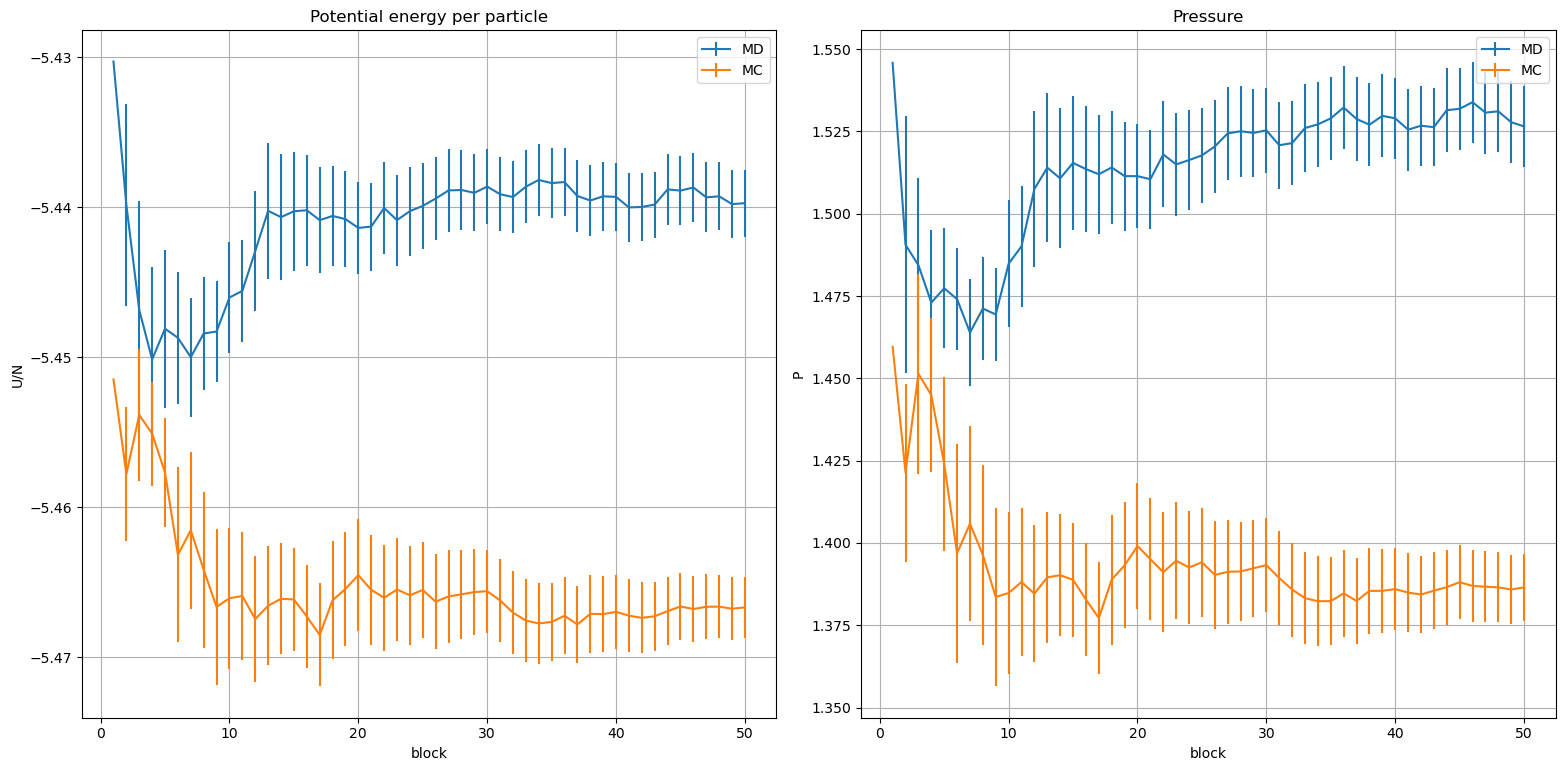

In [26]:
blocks = np.arange(50)+1
u_md, uerr_md = np.loadtxt("Es4/OUTPUT_MD/potential_energy.dat", usecols=(2,3), unpack='true')
u_mc, uerr_mc = np.loadtxt("Es4/OUTPUT_MC/potential_energy.dat", usecols=(2,3), unpack='true')
p_md, perr_md = np.loadtxt("Es4/OUTPUT_MD/pressure.dat", usecols=(2,3), unpack='true')
p_mc, perr_mc = np.loadtxt("Es4/OUTPUT_MC/pressure.dat", usecols=(2,3), unpack='true')

fig, axes = plt.subplots(1, 2, figsize=(16,8))
fig.tight_layout(pad=3.0)

axes[0].errorbar(blocks,u_md,yerr=uerr_md,label='MD')
axes[0].errorbar(blocks,u_mc,yerr=uerr_mc,label='MC')
axes[0].set_xlabel('block')
axes[0].set_ylabel('U/N')
axes[0].set_title('Potential energy per particle')
axes[0].legend()
axes[0].grid(True)

axes[1].errorbar(blocks,p_md,yerr=perr_md,label='MD')
axes[1].errorbar(blocks,p_mc,yerr=perr_mc,label='MC')
axes[1].set_xlabel('block')
axes[1].set_ylabel('P')
axes[1].set_title('Pressure')
axes[1].legend()
axes[1].grid(True)

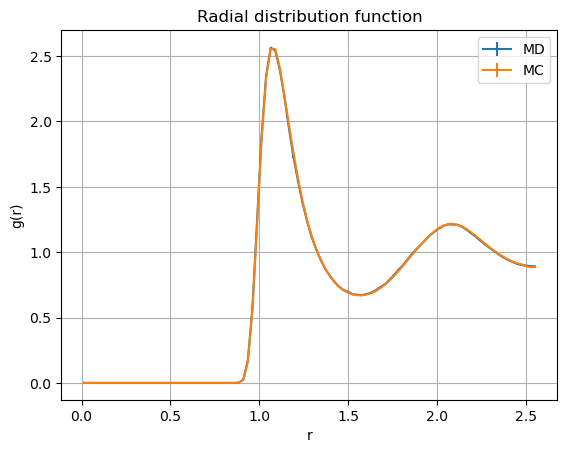

In [30]:
r, g_md, gerr_md = np.loadtxt("Es4/OUTPUT_MD/gofr.dat", skiprows=4999, usecols=(0,2,3), unpack='true')
g_mc, gerr_mc = np.loadtxt("Es4/OUTPUT_MC/gofr.dat", skiprows=4999, usecols=(2,3), unpack='true')

plt.errorbar(r,g_md,yerr=gerr_md,label='MD')
plt.errorbar(r,g_mc,yerr=gerr_mc,label='MC')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial distribution function')
plt.legend()
plt.grid(True)
plt.show()

I valori di energia potenziale e pressione risultano abbastanza simili nei due casi, ma non compatibili tra loro entro le incertezze statistiche. Questa discrepanza osservata dipende probabilmente dal fatto che le due tipologie di simulazione sono formalmente equivalenti soltanto nel limite termodinamico, in cui numero di particelle e volume diventano molto grandi mantenendo la densità costante.

D'altra parte, le due funzioni di distribuzione radiale sono perfettamente sovrapposte e riproducono correttamente l'andamento teorico atteso. Questo conferma che entrambi i metodi descrivono in modo adeguato il comportamento del sistema.